## 목차
1. 데이터셋 준비
2. 기본 CNN 모델 설계
3. Transfer Learning (ResNet50)
4. Fine Tuning 및 성능 비교 (Pre vs Post)
5. CNN 시각화
   - 5.1 Filter Visualization
   - 5.2 Feature Map Visualization
6. 추가 보너스: Tiny ImageNet 비교


## 1. 데이터셋 준비

### 1.1 Caltech101 수동 다운로드 및 압축 해제
```bash
# 브라우저에서 다운로드
https://data.caltech.edu/records/mzrjq-6wc02
# 데이터 폴더로 이동 후 압축 해제
cd ./data
tar -xzvf 101_ObjectCategories.tar.gz
tar -xvf Annotations.tar
```

### 1.2 Transform 정의 및 BinaryCaltech 클래스

In [ ]:
from torchvision.datasets import Caltech101
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch

# 1) Transform 정의
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 2) 전체 Caltech101 불러오기
full_dataset = Caltech101(root='./data', download=False, transform=transform)

# 3) 동물 / 비동물 클래스 목록 (실제 디렉토리 이름 반영)
animal_classes    = ['dalmatian', 'leopards', 'wild_cat', 'horse', 'deer']
nonanimal_classes = ['airplanes', 'car_side', 'ship', 'truck', 'bicycle']

# 4) BinaryCaltech 래퍼 정의
class BinaryCaltech(Dataset):
    def __init__(self, caltech_ds, animal_list, nonanimal_list):
        self.ds = caltech_ds
        self.animal = set(animal_list)
        self.nonanimal = set(nonanimal_list)
        self.indices = [
            i for i, t in enumerate(self.ds.y)
            if self.ds.categories[t] in (*animal_list, *nonanimal_list)
        ]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, orig_label = self.ds[self.indices[idx]]
        name = self.ds.categories[orig_label]
        
        binary_label = 0 if name in self.animal else 1 # 동물/비동물
        return img, binary_label

# 5) BinaryCaltech 데이터셋 생성 및 분할
binary_ds = BinaryCaltech(full_dataset, animal_classes, nonanimal_classes)
train_size = int(0.8 * len(binary_ds))
val_size = len(binary_ds) - train_size
train_ds, val_ds = random_split(binary_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# 배치 확인
images, labels = next(iter(train_loader))

Batch images shape: torch.Size([32, 3, 224, 224]), labels unique: tensor([0, 1])


### “동물(0) vs 비동물(1)” 이진 분류용 데이터셋 생성 방법

원본 Caltech101에 포함된 101개 클래스 중 우리가 정의한 5개 동물과 5개 비동물 카테고리만 추려 “동물(0) vs 비동물(1)” 이진 분류용 데이터셋을 생성


1. 관심 클래스 목록 정의

동물 클래스: 디렉토리 이름 중 실제 동물 항목만 추려낸 ['dalmatian', 'leopards', 'wild_cat', 'horse', 'deer']

비동물 클래스: ['airplanes', 'car_side', 'ship', 'truck', 'bicycle']

2. BinaryCaltech 래퍼로 필터링 및 라벨 매핑

원본 Caltech101 데이터셋의 내부 속성 y(각 이미지의 클래스 인덱스)와 categories(인덱스→디렉토리 이름)를 활용

지정한 동·비동물 리스트에 해당하는 인덱스만 남기는 self.indices 생성

__getitem__() 호출 시

원본 데이터셋에서 이미지와 원래 클래스 인덱스를 가져오고

클래스 이름이 동물 리스트에 있으면 0, 그렇지 않으면 1 을 반환



## 2. 기본 CNN 모델 설계

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64*56*56, 128)
        self.fc2   = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN()

## 3. Transfer Learning (ResNet50)

In [ ]:
from torchvision import models

model = models.resnet50(pretrained=True)



model.fc = nn.Linear(model.fc.in_features, 2)

# feature freeze
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4. Fine Tuning 및 성능 비교 (Pre vs Post)

In [ ]:
import torch
import torch.optim as optim

# 1) Device 설정 (MPS 지원 포함)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("사용 디바이스:", device)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, momentum=0.9)

# 2) Fine-tuning 전 Validation 성능
model.eval()
val_loss0 = val_correct0 = val_total0 = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        val_loss0 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct0 += (preds == labels).sum().item()
        val_total0 += labels.size(0)
val_loss0 /= val_total0
val_acc0 = val_correct0 / val_total0
print(f"Fine-tuning 전 -> Val Loss: {val_loss0:.4f}, Val Acc: {val_acc0:.4f}")

# 3) Fine-tuning (5 Epoch)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = train_correct = train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    print(f"Epoch {epoch+1} Train Loss: {train_loss/train_total:.4f}, Train Acc: {train_correct/train_total:.4f}")

# 4) Fine-tuning 후 Validation 성능
model.eval()
val_loss1 = val_correct1 = val_total1 = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss1 += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct1 += (preds == labels).sum().item()
        val_total1 += labels.size(0)
val_loss1 /= val_total1
val_acc1 = val_correct1 / val_total1
print(f"Fine-tuning 후 -> Val Loss: {val_loss1:.4f}, Val Acc: {val_acc1:.4f}")

사용 디바이스: mps
Fine-tuning 전 -> Val Loss: 0.6469, Val Acc: 0.6732
Epoch 1 Train Loss: 0.2929, Train Acc: 0.8962
Epoch 2 Train Loss: 0.0935, Train Acc: 0.9768
Epoch 3 Train Loss: 0.0451, Train Acc: 0.9963
Epoch 4 Train Loss: 0.0336, Train Acc: 0.9963
Epoch 5 Train Loss: 0.0256, Train Acc: 0.9976
Fine-tuning 후 -> Val Loss: 0.0241, Val Acc: 1.0000


## 5. CNN 시각화

### 5.1 Filter Visualization
Conv1 계층의 필터를 시각화합니다.

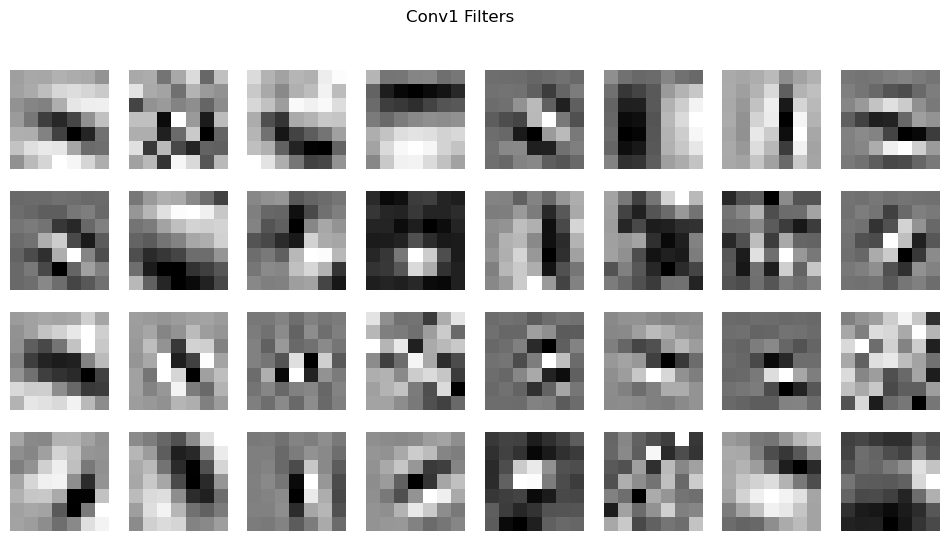

In [ ]:
import matplotlib.pyplot as plt

weights = model.conv1.weight.data.cpu()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):

    kernel = weights[i].mean(0)  # 채널 평균
    
    ax.imshow(kernel, cmap='gray')
    ax.axis('off')
plt.suptitle("Conv1 Filters")
plt.show()

### 5.2 Feature Map Visualization
특정 이미지가 ResNet50의 Conv Layer를 통과하면서 얻어진 Feature Map을 시각화합니다.

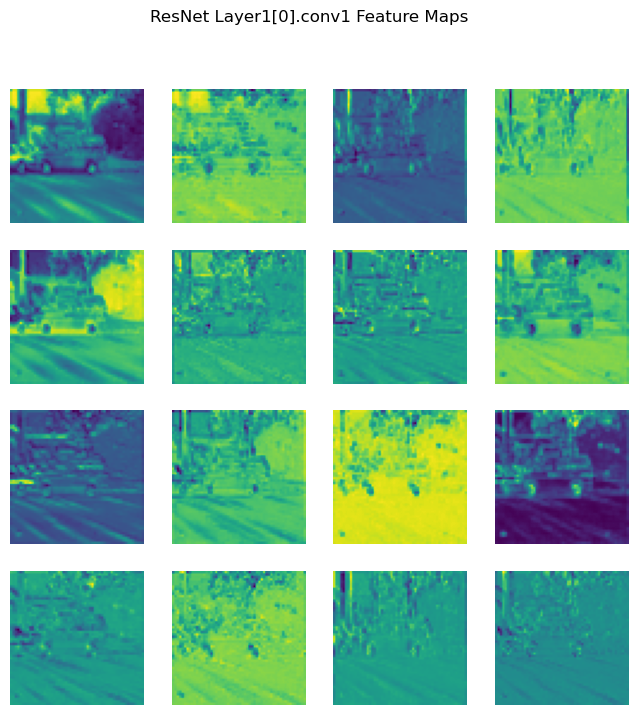

In [ ]:
# Hook을 사용해서 feature map 획득
features = {}
def hook_fn(module, inp, out):
    features['layer1'] = out

model.layer1[0].conv1.register_forward_hook(hook_fn)

# Validation 배치에서 첫 이미지 전달
img_batch, _ = next(iter(val_loader))
_ = model(img_batch.to(device))

# feature map 시각화 (첫 배치, 첫 채널 16개)
fm = features['layer1'][0].cpu().detach()
import matplotlib.pyplot as plt

n_maps = min(16, fm.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(n_maps):
    
    ax = axes.flatten()[i]
    ax.imshow(fm[i], cmap='viridis')    
    ax.axis('off')
plt.suptitle("ResNet Layer1[0].conv1 Feature Maps")
plt.show()

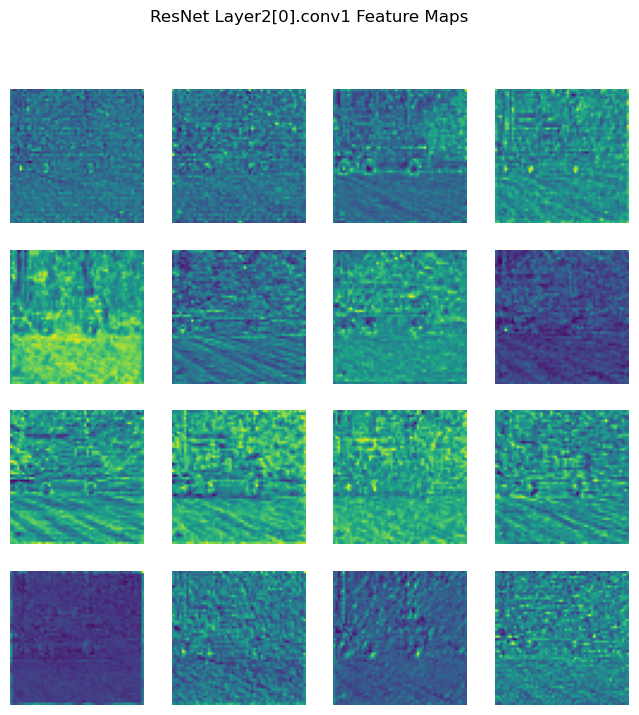

In [7]:
# 5.2.2 Layer2[0].conv1 Feature Maps
features = {}
def hook_l2(module, inp, out):
    features['layer2'] = out

model.layer2[0].conv1.register_forward_hook(hook_l2)
_ = model(img_batch.to(device))
fm2 = features['layer2'][0].cpu().detach()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(min(16, fm2.shape[0])):
    ax = axes.flatten()[i]
    ax.imshow(fm2[i], cmap='viridis')
    ax.axis('off')
plt.suptitle("ResNet Layer2[0].conv1 Feature Maps")
plt.show()

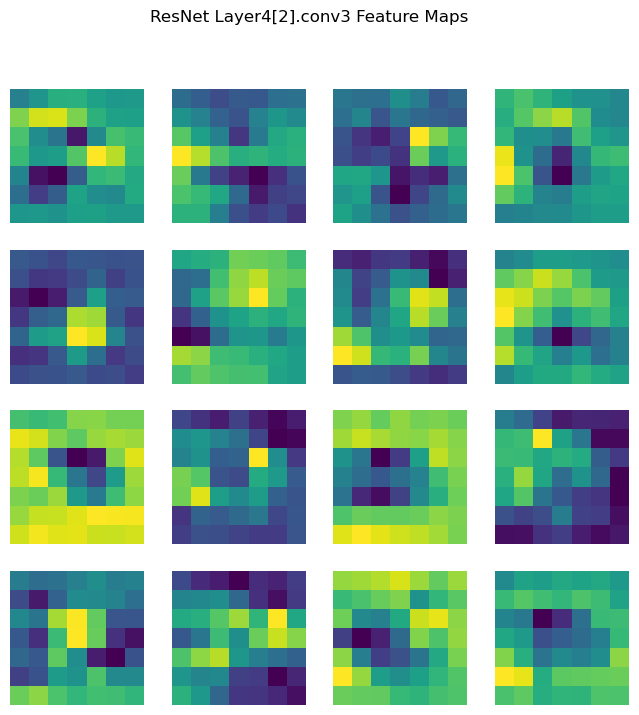

In [8]:
# 5.2.3 Layer4[2].conv3 (마지막 Bottleneck conv) Feature Maps
features = {}
def hook_l4(module, inp, out):
    features['layer4'] = out

# 마지막 Bottleneck 블록의 conv3
model.layer4[2].conv3.register_forward_hook(hook_l4)
_ = model(img_batch.to(device))
fm4 = features['layer4'][0].cpu().detach()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(min(16, fm4.shape[0])):
    ax = axes.flatten()[i]
    ax.imshow(fm4[i], cmap='viridis')
    ax.axis('off')
plt.suptitle("ResNet Layer4[2].conv3 Feature Maps")
plt.show()

## 6. 추가 보너스: Tiny ImageNet 비교
- Tiny ImageNet 데이터셋 로드 후 동일한 파이프라인 적용하고 결과 비교